In [9]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib

from id01lib import id01h5
from id01lib.xrd.qconversion import scan_to_qspace_h5,qconvert_mgrid
from id01lib.xrd.geometries import ID01psic
from mpl_toolkits.axes_grid1 import make_axes_locatable
from silx.io import specfile as spec
from ipywidgets import interact

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['font.size'] = 10

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%gui qt5

In [2]:
# Sample and scans
fname = '/users/zatterin/Documents/beam/20170712_HC2912/data/hc2912.h5'
sample = 'E16095_furnace'
scan_no = 34

# Experimental parameters
det_distance =  0.422
cen_pix = [281.847,278.792] # x, y
nrj=8
nbins = (200,200,200)
# nbins = (-1,-1,-1)

# Open the h5 file
with h5py.File(fname) as h5f:
    
    # read / set offsets
    scan = h5f['/{0}/{1}.1'.format(sample,scan_no)]
    phi_off = h5f['/{0}/{1}.1/instrument/positioners/phi'.format(sample,scan_no)].value
    rhx_off = h5f['/{0}/{1}.1/instrument/positioners/rhx'.format(sample,scan_no)].value
    rhy_off = h5f['/{0}/{1}.1/instrument/positioners/rhy'.format(sample,scan_no)].value
    nu_off =  h5f['/{0}/{1}.1/instrument/positioners/nu'.format(sample,scan_no)].value
    ID01psic().usemotors = set(('eta', 'phi', 'nu', 'delta'))
    
    # set to corresponding offsets if needed
    ID01psic().set_offsets(eta=0, rhy=0, rhx=0.656, phi=1.994, nu=0)
    
    # convert to q space
    qx, qy, qz, gint = scan_to_qspace_h5(scan, 
                                         cen_pix=(cen_pix[1],cen_pix[0]), 
                                         distance=det_distance, 
                                         energy=8,
                                         nbins=nbins)

Selected /E16095_furnace/34.1
Offsets used: eta = 0.0, rhx = 0.656, nu = 0.0, phi = 1.994, rhy = 0.0, rhz = 0.0, mu = 0.0, delta = 0.0, 
Max. number of bins: 355, 532, 518
Using binning: (200, 200, 200)


In [3]:
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 4.5)


Gridding with bins: (200, 200, 200)


In [4]:
i.min(), i.max()

(1.9840718817214302, 6.48407188172143)

In [12]:
plt.clim?

In [29]:
%matplotlib inline

@interact(n=(0,i.shape[2],1))
def plt_zslice(n=50, savefig=False):
    maskedi = np.ma.masked_where(i<=i.min(),i)
    toplot = maskedi[:,:,n]
    # toplot = np.log(gint.sum(0))

    fig = plt.figure(dpi=150, facecolor='white')
    ax = plt.gca()
    ax.axis('equal')

    im = plt.contourf(qxx[:,:,0],qyy[:,:,0],toplot,30,cmap='jet', vmin=2, vmax=4.5)

    plt.locator_params(axis='x',nbins=5)
    plt.locator_params(axis='y',nbins=5)

    # Colorbar hacks
    divider = make_axes_locatable(ax)
    coloraxis = divider.append_axes('top', size='5%', pad=0.05)
    cbar = plt.colorbar(im, cax=coloraxis, orientation="horizontal")
    coloraxis.xaxis.set_ticks_position("top")
    tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.ax.tick_params(labelsize=10)
    cbar.update_ticks()

    # Labels etc
    ax.set_ylabel(r'$\mathbf{Q_y}$')
    ax.set_xlabel(r'$\mathbf{Q_x}$')
    ax.set_xlim(-0.1, 0.1)
    ax.set_ylim(-0.1, 0.1)

    if savefig:
        plt.savefig('001cut_{0}.pdf'.format(n))

interactive(children=(IntSlider(value=50, description='n', max=200), Checkbox(value=False, description='savefi…

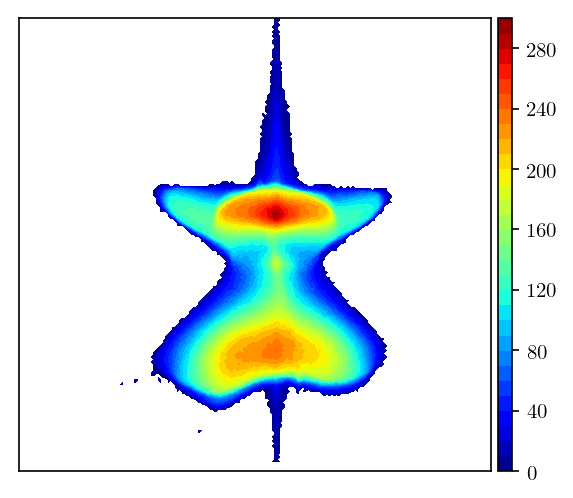

In [38]:
%matplotlib inline
# toplot = np.log(gint.sum(0))
maskedi = np.ma.masked_where(i<=i.min(),i)
toplot = maskedi.sum(1)

fig = plt.figure(dpi=150, facecolor='white')
ax = plt.gca()
ax.axis('equal')

im = plt.contourf(qxx[:,0,:],qzz[:,0,:],toplot,30,cmap='jet',vmax=300)

divider = make_axes_locatable(ax)
coloraxis = divider.append_axes('right', size='3%', pad=0.05)
cbar = plt.colorbar(im, cax=coloraxis)

ax.tick_params(axis='both',bottom=False, left=False, labelleft=False, labelbottom=False)

# plt.savefig('001y.svg')